In [88]:
#Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [89]:
df=pd.read_csv("/kaggle/input/datatestt/Gia SMP va SMPcap 2021(Gi th trng SMP).csv",encoding='ISO-8859-1')
dfs = pd.concat([df["Ngày"], df["11"]], axis=1)
print(dfs)

           Ngày      11
0     01/1/2021   964.4
1     01/2/2021  1019.7
2     01/3/2021   988.4
3     01/4/2021  1010.8
4     01/5/2021  1061.5
..          ...     ...
360  27/12/2021  1002.0
361  28/12/2021  1002.0
362  29/12/2021  1061.5
363  30/12/2021  1022.6
364  31/12/2021  1022.6

[365 rows x 2 columns]


In [90]:
feats= ['11']

In [91]:
from sklearn.preprocessing import PowerTransformer

# Chuyển đổi cột '11' thành mảng 2D
X = df['11'].values.reshape(-1, 1)

# Áp dụng PowerTransformer
transformer = PowerTransformer()
X_transformed = transformer.fit_transform(X)

In [92]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)

#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= preds

In [93]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(7)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [94]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

[200]	valid_0's multi_logloss: 0.000151038
[400]	valid_0's multi_logloss: 0.000151038
[200]	valid_0's multi_logloss: 0.000151576
[400]	valid_0's multi_logloss: 0.000151576
[200]	valid_0's multi_logloss: 0.00015433
[400]	valid_0's multi_logloss: 0.00015433
[200]	valid_0's multi_logloss: 0.000155486
[400]	valid_0's multi_logloss: 0.000155486
[200]	valid_0's multi_logloss: 0.000153559
[400]	valid_0's multi_logloss: 0.000153559
[200]	valid_0's multi_logloss: 0.000155711
[400]	valid_0's multi_logloss: 0.000155711
[200]	valid_0's multi_logloss: 8.58365e-06
[400]	valid_0's multi_logloss: 8.48634e-06
[600]	valid_0's multi_logloss: 8.42158e-06
[800]	valid_0's multi_logloss: 8.37546e-06
[1000]	valid_0's multi_logloss: 8.34101e-06
[1200]	valid_0's multi_logloss: 8.3143e-06
[1400]	valid_0's multi_logloss: 8.29302e-06
[1600]	valid_0's multi_logloss: 8.27566e-06
[1800]	valid_0's multi_logloss: 8.26123e-06
[2000]	valid_0's multi_logloss: 8.24906e-06
[2200]	valid_0's multi_logloss: 8.23866e-06
[2400]	

In [95]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [96]:
labels=np.argmax(lgb_preds,axis=1)

In [97]:
import numpy as np
# Tính chuỗi return
r_t = np.log(dfs['11'] / dfs['11'].shift(1)).values

In [98]:
mean = np.nanmean(r_t)
r_t[0]=mean
r_t[:5]

array([ 0.00016098,  0.0557576 , -0.03117627,  0.0224099 ,  0.04894091])

In [99]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(r_t)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.350805
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


<Figure size 800x600 with 0 Axes>

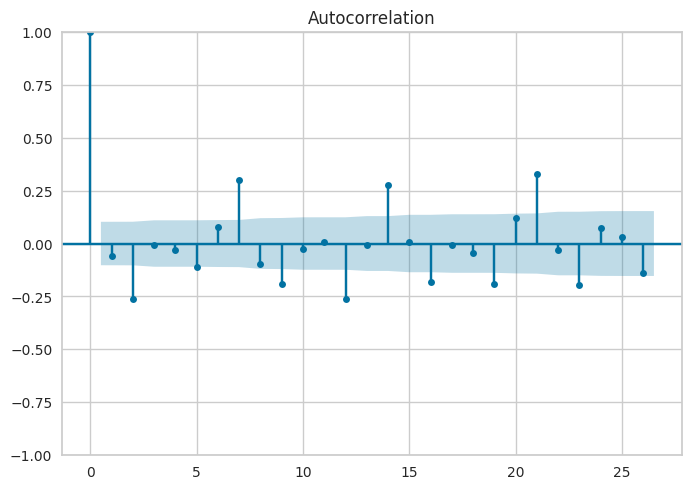

In [100]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax1 = plot_acf(r_t)

<Figure size 800x600 with 0 Axes>

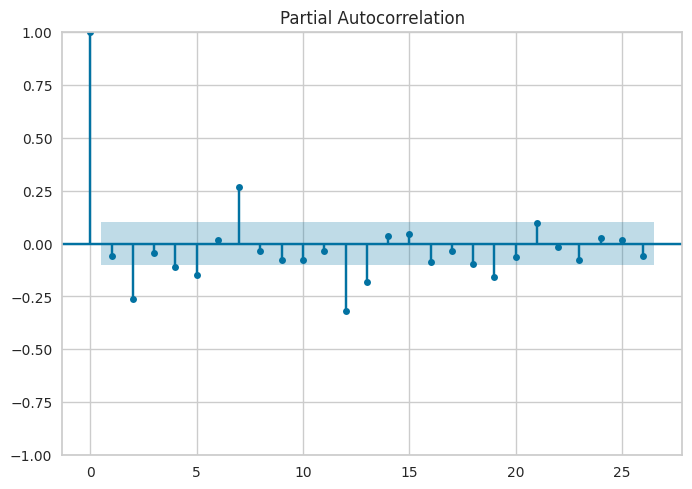

In [101]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax2 = plot_pacf(r_t)

In [102]:
from statsmodels.tsa.arima.model import ARIMA

# Khởi tạo và phù hợp với mô hình ARIMA
model_arima = ARIMA(r_t, order=(2, 0, 2))
model_fit = model_arima.fit()

# In ra tóm tắt của mô hình
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 562.860
Date:                Tue, 07 May 2024   AIC                          -1113.721
Time:                        02:31:15   BIC                          -1090.321
Sample:                             0   HQIC                         -1104.421
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.230      0.818      -0.002       0.002
ar.L1         -0.1327      0.063     -2.121      0.034      -0.255      -0.010
ar.L2          0.5292      0.056      9.382      0.0